# Portfolio Optimization and Analysis

#### Imports

In [1]:
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from statsmodels import regression
import statsmodels.api as sm
from scipy.optimize import minimize
import pyfolio as pf
import empyrical
%matplotlib inline

#### Get Quandl private key

In [2]:
quandl_private_key = open('private/quandlKey.txt', 'r').read()

#### Period of the analysis

In [3]:
start_date = pd.to_datetime('2017-02-01')
end_date = pd.to_datetime('2018-10-22')

#### Create the portfolio

In [4]:
portfolio_list = ['INDUSINDBK', 'BRITANNIA', 'ASIANPAINT', 'JSWSTEEL']

In [5]:
portfolio_close_price = pd.DataFrame()

for stock in portfolio_list:
    portfolio_close_price[stock] = quandl.get("NSE/{}.5".format(stock), authtoken=quandl_private_key, start_date=start_date, end_date=end_date)['Close']

In [6]:
portfolio_close_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2017-02-01 to 2018-10-22
Data columns (total 4 columns):
INDUSINDBK    426 non-null float64
BRITANNIA     426 non-null float64
ASIANPAINT    426 non-null float64
JSWSTEEL      426 non-null float64
dtypes: float64(4)
memory usage: 16.6 KB


In [7]:
portfolio_close_price.describe()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
count,426.000000,426.000000,426.000000,426.000000
mean,1673.016197,4709.515962,1183.138498,270.907394
std,190.516597,1018.189364,101.998910,61.461676
min,1284.000000,3059.150000,960.800000,176.250000
25%,1526.437500,3721.300000,1126.825000,213.487500
50%,1670.075000,4706.475000,1157.025000,265.850000
75%,1846.712500,5502.862500,1249.675000,317.100000
max,2023.050000,6900.150000,1467.750000,417.050000


In [8]:
portfolio_close_price.head()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
Date,,,,
2017-02-01,1307.75,3234.75,991.0,197.30
2017-02-02,1284.00,3231.00,989.0,193.90
2017-02-03,1303.20,3230.85,985.9,191.65
2017-02-06,1317.05,3285.00,992.5,192.35
2017-02-07,1324.25,3230.60,999.3,189.00


In [9]:
portfolio_close_price.to_csv('portfolio_close.csv')

#### Normalize Prices
This is the same as cumulative daily returns

In [10]:
portfolio_close_price_normalized = portfolio_close_price.copy()

for stock in portfolio_close_price.columns:
    portfolio_close_price_normalized[stock] = portfolio_close_price[stock]/portfolio_close_price.iloc[0][stock]

In [12]:
portfolio_close_price_normalized.head()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
Date,,,,
2017-02-01,1.000000,1.000000,1.000000,1.000000
2017-02-02,0.981839,0.998841,0.997982,0.982767
2017-02-03,0.996521,0.998794,0.994854,0.971363
2017-02-06,1.007111,1.015534,1.001514,0.974911
2017-02-07,1.012617,0.998717,1.008375,0.957932


In [13]:
portfolio_close_price_normalized.tail()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
Date,,,,
2018-10-15,1.244083,1.753335,1.261655,1.909782
2018-10-16,1.239189,1.762269,1.279112,1.893563
2018-10-17,1.226458,1.712976,1.270434,1.832995
2018-10-19,1.205659,1.719917,1.246620,1.842372
2018-10-22,1.108354,1.725064,1.211302,1.799797


#### Allocations

In [14]:
# Before optimization guess
#30% in Stock 1
#20% in Stock 2
#40% in Stock 3
#10% in Stock 4
#allocation = [0.3,0.2,0.4,0.1]

# We found this after optimization
allocation = [0.26336622, 0.34829266, 0.31256747, 0.07577365]

In [15]:
portfolio_size = 1000000

In [16]:
portfolio_normalized_allocation = portfolio_close_price_normalized.copy()

allocation_index = 0

for stock in portfolio_close_price_normalized.columns:
    portfolio_normalized_allocation[stock] = portfolio_close_price_normalized[stock].apply(lambda normalized_return : normalized_return * allocation[allocation_index] * portfolio_size)
    allocation_index += 1

In [17]:
portfolio_normalized_allocation.head()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
Date,,,,
2017-02-01,263366.220000,348292.660000,312567.470000,75773.650000
2017-02-02,258583.235695,347888.889237,311936.657750,74467.869919
2017-02-03,262449.900902,347872.738407,310958.898762,73603.750748
2017-02-06,265239.135959,353703.188222,313040.579188,73872.587823
2017-02-07,266689.135412,347845.820356,315185.340839,72586.010390


In [18]:
portfolio_normalized_allocation['Total Position'] = portfolio_normalized_allocation.sum(axis=1)

In [19]:
portfolio_normalized_allocation.tail()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL,Total Position
Date,,,,,
2018-10-15,327649.529061,610673.668894,394352.278245,144711.157223,1.477387e+06
2018-10-16,326360.640658,613785.395573,399808.804210,143482.187734,1.483437e+06
2018-10-17,323007.516924,596617.062738,397096.311534,138892.754802,1.455614e+06
2018-10-19,317529.741215,599034.303705,389652.726981,139603.252788,1.445820e+06
2018-10-22,291903.014780,600827.045892,378613.512601,136377.207881,1.407721e+06


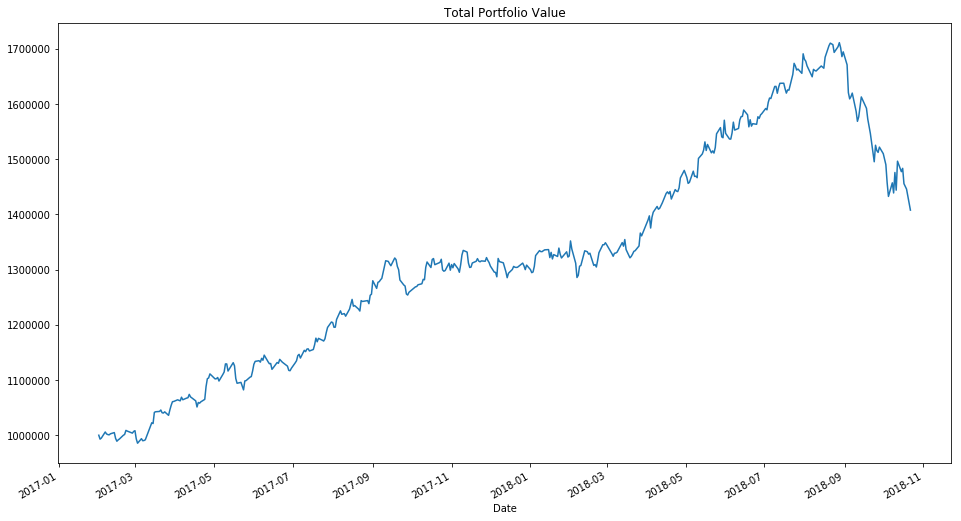

In [20]:
portfolio_normalized_allocation['Total Position'].plot(figsize=(16,9))
plt.title('Total Portfolio Value');

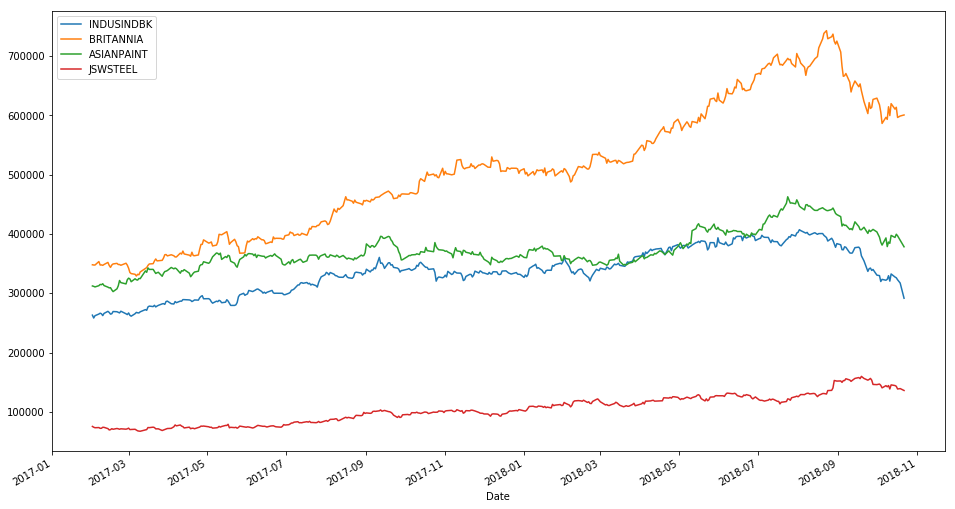

In [21]:
portfolio_normalized_allocation.drop('Total Position',axis=1).plot(kind='line', figsize=(16,9));

## Portfolio Statistics

#### Daily Returns

In [22]:
portfolio_normalized_allocation['Daily Return'] = portfolio_normalized_allocation['Total Position'].pct_change(1)

In [23]:
portfolio_normalized_allocation.head()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL,Total Position,Daily Return
Date,,,,,,
2017-02-01,263366.220000,348292.660000,312567.470000,75773.650000,1.000000e+06,NaN
2017-02-02,258583.235695,347888.889237,311936.657750,74467.869919,9.928767e+05,-0.007123
2017-02-03,262449.900902,347872.738407,310958.898762,73603.750748,9.948853e+05,0.002023
2017-02-06,265239.135959,353703.188222,313040.579188,73872.587823,1.005855e+06,0.011027
2017-02-07,266689.135412,347845.820356,315185.340839,72586.010390,1.002306e+06,-0.003529


In [24]:
#Overall Cumulative Return (not daily)
cumulative_return = 100 * (portfolio_normalized_allocation['Total Position'][-1]/portfolio_normalized_allocation['Total Position'][0] - 1 )
print('Our return was {}%!'.format(round(cumulative_return,2)))

Our return was 40.77%!


#### Avg Daily Return

In [25]:
portfolio_normalized_allocation['Daily Return'].mean()

0.0008449931073438904

#### Standard Deviation of Daily Return

In [26]:
portfolio_normalized_allocation['Daily Return'].std()

0.00896274180428624

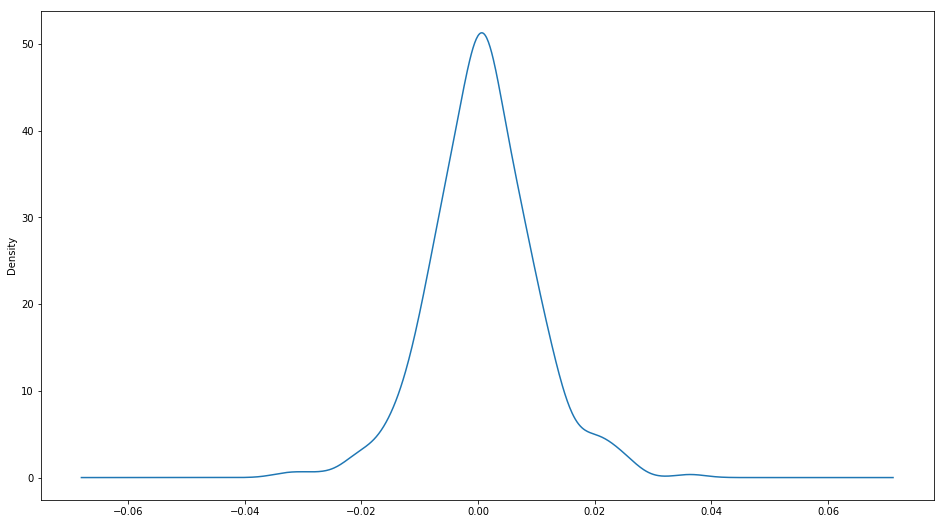

In [27]:
portfolio_normalized_allocation['Daily Return'].plot(kind='kde', figsize=(16,9));

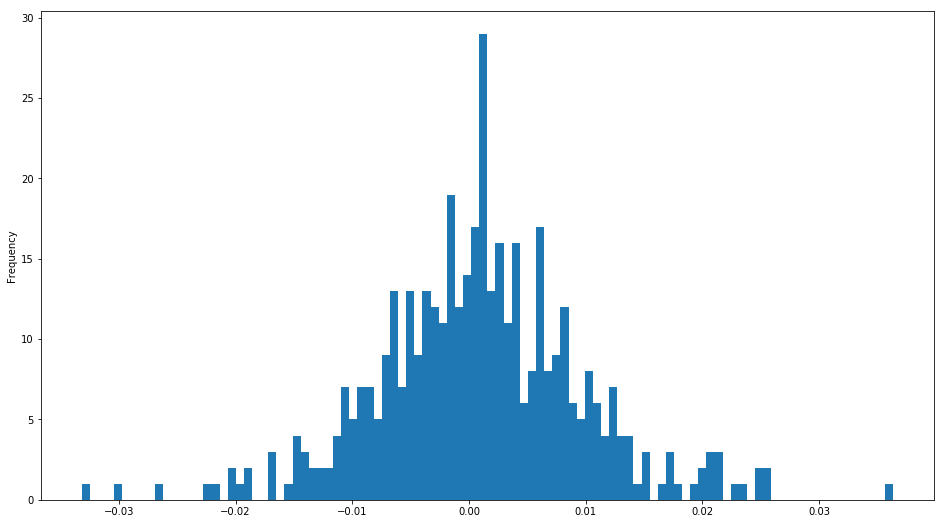

In [71]:
portfolio_normalized_allocation['Daily Return'].plot(kind='hist', bins=100, figsize=(16,9));

# Sharpe Ratio
The Sharpe Ratio is a measure for calculating risk-adjusted return, and this ratio has become the industry standard for such calculations.

Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return

The original Sharpe Ratio

Annualized Sharpe Ratio = K-value * SR

K-values for various sampling rates:

Daily = sqrt(252)
Weekly = sqrt(52)
Monthly = sqrt(12)

In [28]:
daily_rate = ((1.0 + 7)**(1/252))-1
daily_rate

0.008285891695374081

In [29]:
sharpe_ratio = (portfolio_normalized_allocation['Daily Return'].mean() - daily_rate) / portfolio_normalized_allocation['Daily Return'].std()

In [30]:
sharpe_ratio

-0.8302033853604641

In [31]:
# https://www.investopedia.com/articles/07/sharpe_ratio.asp
annualized_sharpe_ratio = (252**0.5)*sharpe_ratio
annualized_sharpe_ratio

-13.179070171606257

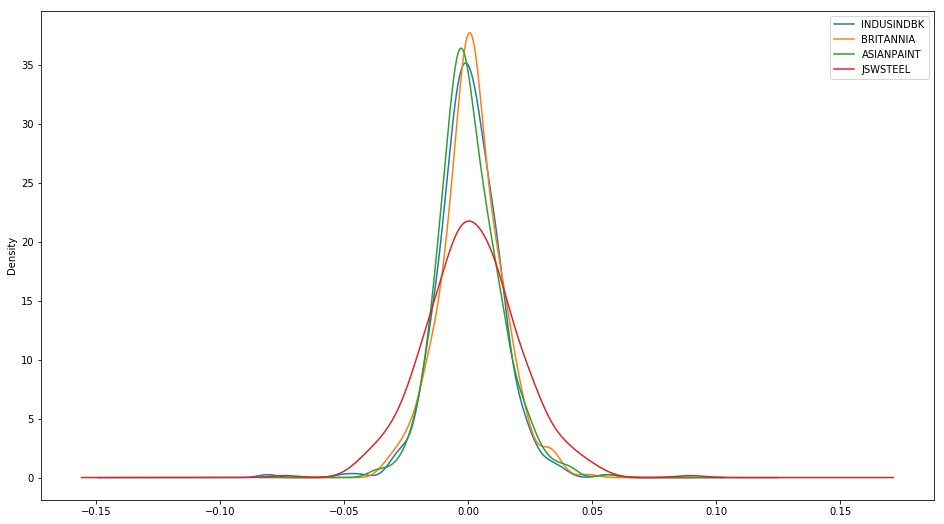

In [32]:
fig, ax = plt.subplots(figsize = (16,9))

for stock in portfolio_close_price.columns:
    portfolio_close_price[stock].pct_change(1).plot('kde')
    ax.legend()

# Hedging

In [33]:
asset_returns = pd.DataFrame(portfolio_normalized_allocation['Daily Return'].iloc[1:])

In [34]:
asset_returns.columns = ['Asset Returns']

In [58]:
benchmark_returns = pd.DataFrame(quandl.get("NSE/{}.4".format('NIFTY_50'), authtoken=quandl_private_key, start_date=start_date, end_date=end_date)['Close'])

In [61]:
benchmark_returns.columns = ['Benchmark Returns']

In [62]:
benchmark_returns_absolute = benchmark_returns.copy()

In [63]:
benchmark_returns_absolute.head()

,Benchmark Returns
Date,
2017-02-01,8716.40
2017-02-02,8734.25
2017-02-03,8740.95
2017-02-06,8801.05
2017-02-07,8768.30


In [64]:
benchmark_returns = pd.DataFrame(benchmark_returns.pct_change()[1:])

In [65]:
benchmark_returns.head()

,Benchmark Returns
Date,
2017-02-02,0.002048
2017-02-03,0.000767
2017-02-06,0.006876
2017-02-07,-0.003721
2017-02-08,0.000086


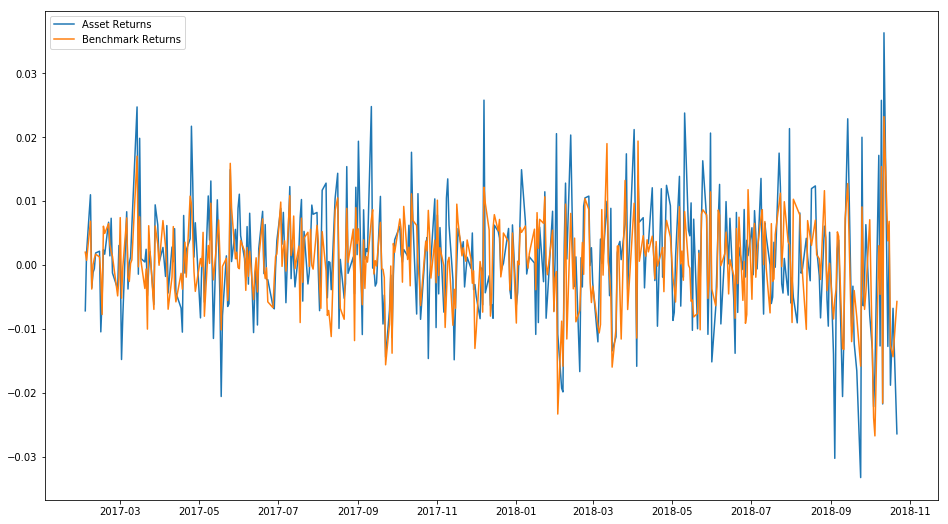

In [66]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(asset_returns['Asset Returns'], label = 'Asset Returns')
ax.plot(benchmark_returns['Benchmark Returns'], label = 'Benchmark Returns')
ax.legend()

#### Regression for Alpha and Beta Values

Text(0, 0.5, 'Asset Returns')

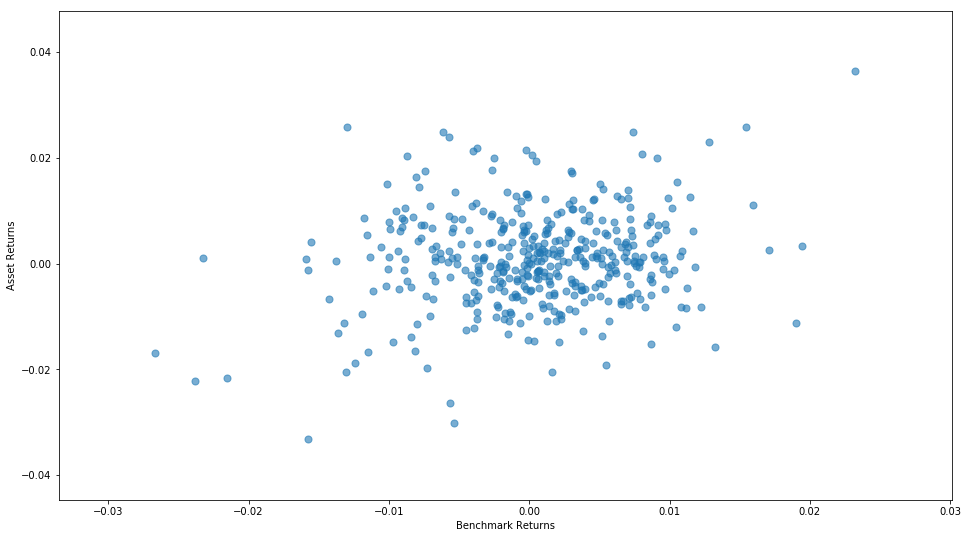

In [67]:
fig, ax = plt.subplots(figsize = (16,9))
plt.scatter(benchmark_returns['Benchmark Returns'][-420:],asset_returns['Asset Returns'][-420:],alpha=0.6,s=50)
plt.xlabel('Benchmark Returns')
plt.ylabel('Asset Returns')

In [68]:
asset_return_values = asset_returns['Asset Returns'][-420:].values
benchmark_return_values = benchmark_returns['Benchmark Returns'][-420:].values

In [69]:
# Add a constant (column of 1s for intercept)
benchmark_constant = sm.add_constant(benchmark_return_values)

# Fit regression to data
model = regression.linear_model.OLS(asset_return_values,benchmark_constant).fit()

In [70]:
alpha , beta = model.params

In [71]:
alpha

0.0007612857754749512

In [72]:
beta

0.22265200595115708

#### Plot Alpha and Beta

Text(0, 0.5, 'Asset Returns')

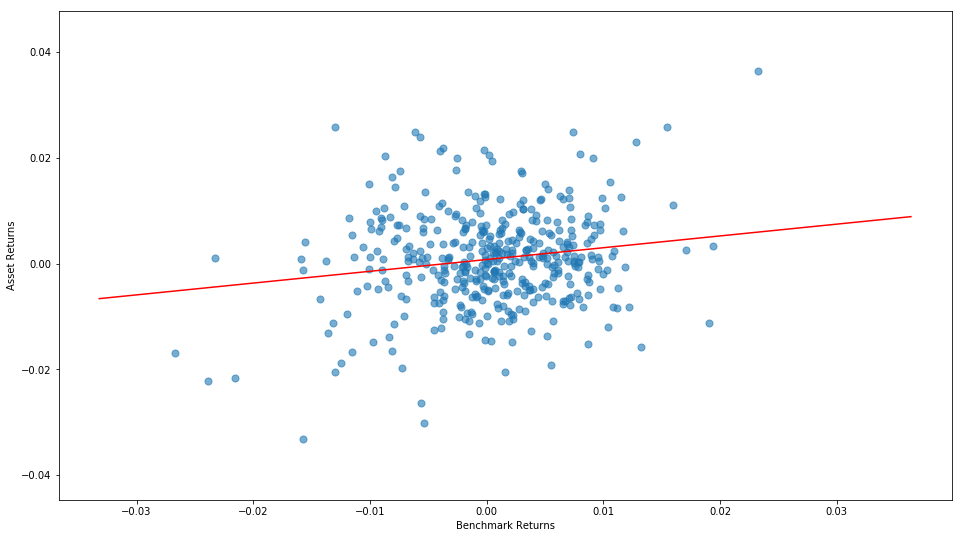

In [73]:
fig, ax = plt.subplots(figsize = (16,9))

# Scatter Returns
plt.scatter(benchmark_returns['Benchmark Returns'][-420:],asset_returns['Asset Returns'][-420:],alpha=0.6,s=50)

# Fit Line
min_benchmark = asset_return_values.min()
max_benchmark = asset_return_values.max()

benchmark_line = np.linspace(min_benchmark,max_benchmark,100)
y = benchmark_line * beta + alpha

plt.plot(benchmark_line,y,'r')

plt.xlabel('Benchmark Returns')
plt.ylabel('Asset Returns')

## Implementing the Hedge

In [74]:
hedged = -1*beta*benchmark_returns['Benchmark Returns'][-420:] + asset_returns['Asset Returns'][-420:]

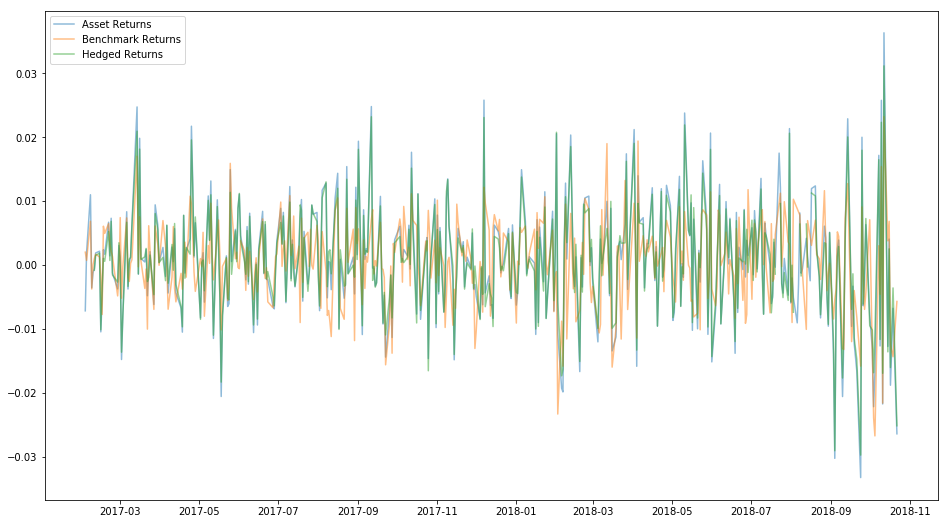

In [75]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(asset_returns['Asset Returns'], label = 'Asset Returns', alpha=0.5)
ax.plot(benchmark_returns['Benchmark Returns'], label = 'Benchmark Returns', alpha=0.5)
ax.plot(hedged, label = 'Hedged Returns', alpha=0.5)

ax.legend()

#### What happens if there is a big market drop?

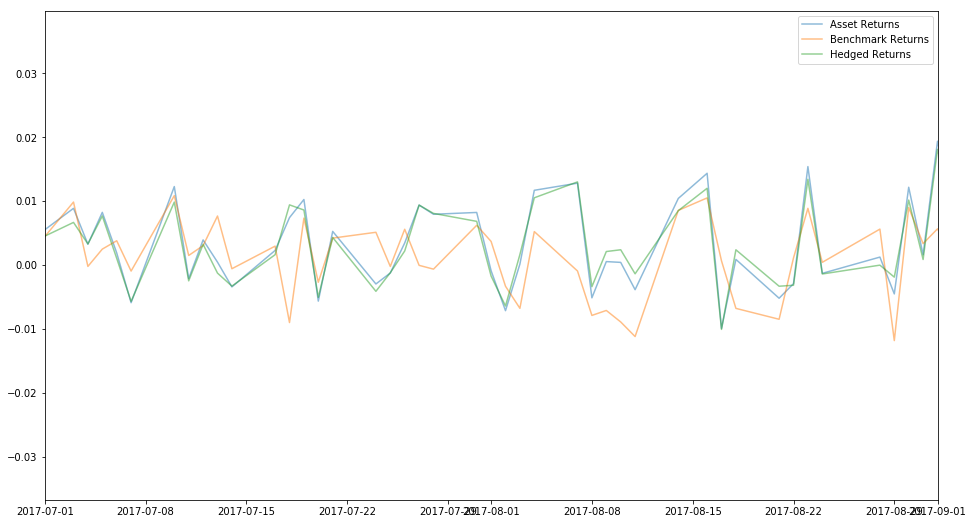

In [76]:
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(asset_returns['Asset Returns'], label = 'Asset Returns', alpha=0.5)
ax.plot(benchmark_returns['Benchmark Returns'], label = 'Benchmark Returns', alpha=0.5)
ax.plot(hedged, label = 'Hedged Returns', alpha=0.5)
ax.set_xlim(['2017-07-01','2017-09-01'])

ax.legend()

In [77]:
hedged.describe()

count    415.000000
mean       0.000768
std        0.008066
min       -0.029684
25%       -0.004028
50%        0.000654
75%        0.005441
max        0.031177
dtype: float64

## Portfolio Optimization

Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper “Portfolio Selection,” (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.

#### Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that. Log returns are convenient to work with in many of the algorithms.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

In [79]:
log_returns = np.log(portfolio_close_price/portfolio_close_price.shift(1))

In [80]:
log_returns.head()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
Date,,,,
2017-02-01,NaN,NaN,NaN,NaN
2017-02-02,-0.018328,-0.001160,-0.002020,-0.017383
2017-02-03,0.014843,-0.000046,-0.003139,-0.011672
2017-02-06,0.010572,0.016621,0.006672,0.003646
2017-02-07,0.005452,-0.016699,0.006828,-0.017570


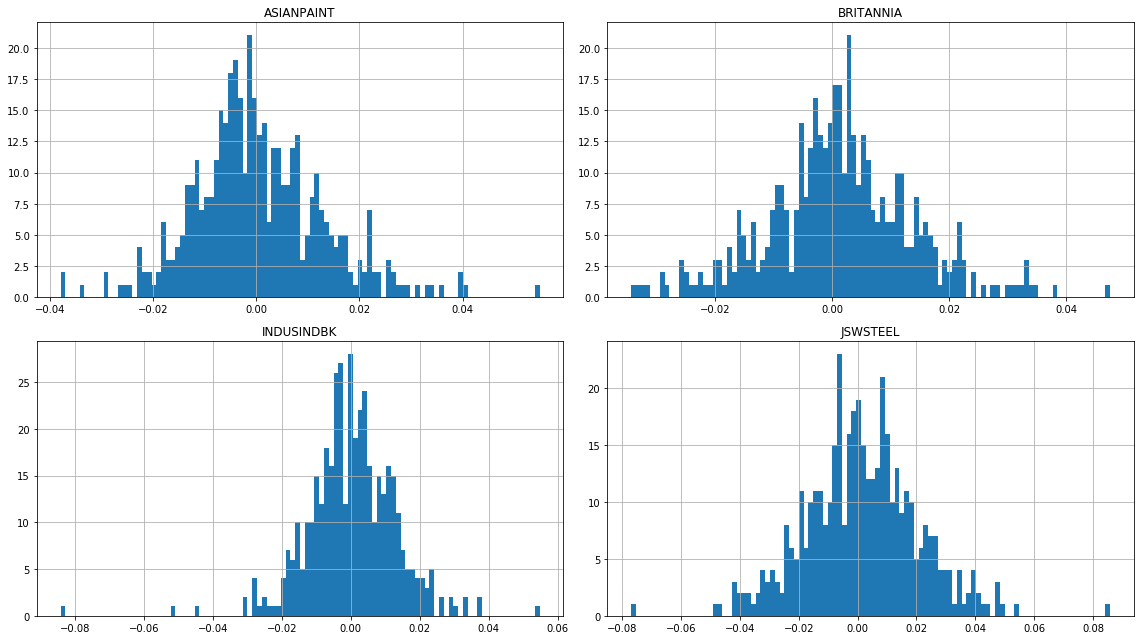

In [81]:
log_returns.hist(bins=100,figsize=(16,9));
plt.tight_layout()

In [82]:
log_returns.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INDUSINDBK,425.0,0.000242,0.012888,-0.084150,-0.006731,0.000030,0.008081,0.054700
BRITANNIA,425.0,0.001283,0.012469,-0.034365,-0.005496,0.001021,0.008611,0.047459
ASIANPAINT,425.0,0.000451,0.012529,-0.037894,-0.007117,-0.000840,0.007371,0.054923
JSWSTEEL,425.0,0.001383,0.019118,-0.076903,-0.010212,0.001069,0.013298,0.085782


In [83]:
log_returns.mean() * 252

INDUSINDBK    0.060999
BRITANNIA     0.323309
ASIANPAINT    0.113664
JSWSTEEL      0.348456
dtype: float64

In [84]:
# Compute pairwise covariance of columns
log_returns.cov()

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
INDUSINDBK,0.000166,0.000042,0.000046,0.000067
BRITANNIA,0.000042,0.000155,0.000039,0.000060
ASIANPAINT,0.000046,0.000039,0.000157,0.000051
JSWSTEEL,0.000067,0.000060,0.000051,0.000366


In [85]:
log_returns.cov()*252 # multiply by days

,INDUSINDBK,BRITANNIA,ASIANPAINT,JSWSTEEL
INDUSINDBK,0.041856,0.010635,0.011591,0.016938
BRITANNIA,0.010635,0.039181,0.009898,0.015227
ASIANPAINT,0.011591,0.009898,0.039557,0.012966
JSWSTEEL,0.016938,0.015227,0.012966,0.092110


### Mathematical Optimization

#### Functionalize Return and SR operations

In [102]:
def get_return_volatility_sharperatio(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    daily_rate = np.log(((1.0 + 7)**(1/252))-1)
    
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = (returns-daily_rate)/volatility
    return np.array([returns,volatility,sharpe_ratio])

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [87]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [103]:
def negative_sharpe(weights):
    return  get_return_volatility_sharperatio(weights)[2] * -1 #sharpe ratio is at 2 index, * -1 to make -ve

In [104]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [105]:
# By convention of minimize function it should be a function that returns zero for conditions
# eq - this is a equation type constraint. "np.sum(weights) - 1" is an equation
cons = ({'type':'eq','fun': check_sum})

In [106]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [107]:
# Initial Guess (equal distribution)
initial_guess = [0.25,0.25,0.25,0.25]

In [108]:
# Sequential Least SQuares Programming (SLSQP).
optimize_results = minimize(negative_sharpe,initial_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [109]:
optimize_results

     fun: -35.10226508144393
     jac: array([33.75979805, 33.75977755, 33.75979805, 33.75986767])
 message: 'Optimization terminated successfully.'
    nfev: 53
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.26336622, 0.34829266, 0.31256747, 0.07577365])

In [110]:
optimize_results.x #Sum add up to one, this is the efficient portfolio allocation

array([0.26336622, 0.34829266, 0.31256747, 0.07577365])

In [111]:
get_return_volatility_sharperatio(optimize_results.x)

array([ 0.19060304,  0.14197956, 35.10226508])

## Monte Carlo Simulation for Optimization Search


We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In [112]:
%%time
numer_of_portfolios = 5000

all_weights = np.zeros((numer_of_portfolios,len(portfolio_close_price.columns))) # number of portfolios X number of stocks in portfolio
return_array = np.zeros(numer_of_portfolios) # return for every portfolio
volatility_array = np.zeros(numer_of_portfolios) # volatility for every portfolio
sharpe_array = np.zeros(numer_of_portfolios) # sharpe ratio for every portfolio

for individual_portfolio in range(numer_of_portfolios):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[individual_portfolio] = weights

    # Expected Return
    return_array[individual_portfolio] = np.sum((log_returns.mean() * weights) *252)

    # Expected Variance
    volatility_array[individual_portfolio] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_array[individual_portfolio] = (return_array[individual_portfolio]-daily_rate)/volatility_array[individual_portfolio]

Wall time: 6.26 s


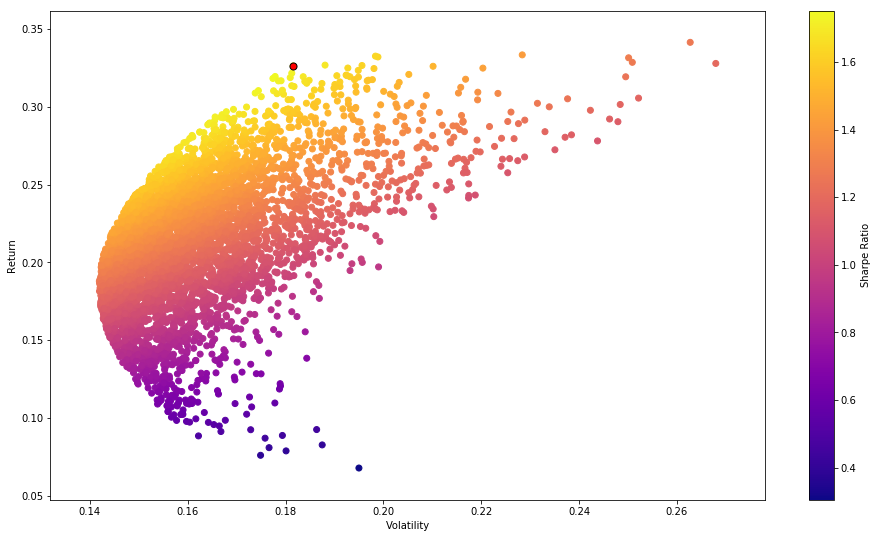

In [113]:
plt.figure(figsize=(16,9))
plt.scatter(volatility_array,return_array,c=sharpe_array,cmap='plasma') #color by sharpe_array
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

max_index = sharpe_array.argmax()
max_sr_ret = return_array[max_index]
max_sr_vol = volatility_array[max_index]

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black');

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

In [114]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100)

In [115]:
def minimize_volatility(weights):
    return  get_return_volatility_sharperatio(weights)[1] # volatility is at index 1

In [116]:
%%time
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_return_volatility_sharperatio(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,initial_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

Wall time: 11.1 s


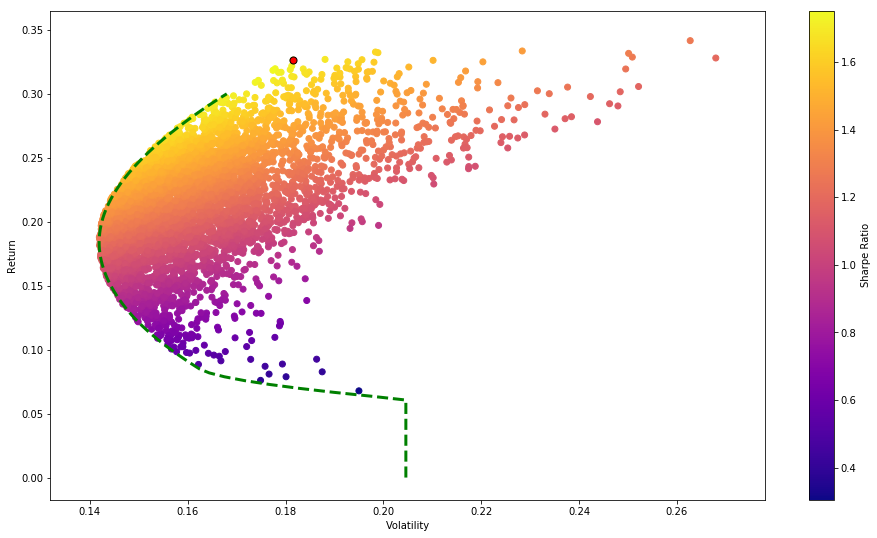

In [117]:
plt.figure(figsize=(16,9))
plt.scatter(volatility_array,return_array,c=sharpe_array,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black');

## Portfolio Analysis

In [118]:
empyrical.beta(portfolio_normalized_allocation['Daily Return'],benchmark_returns)

0.8820454634723552

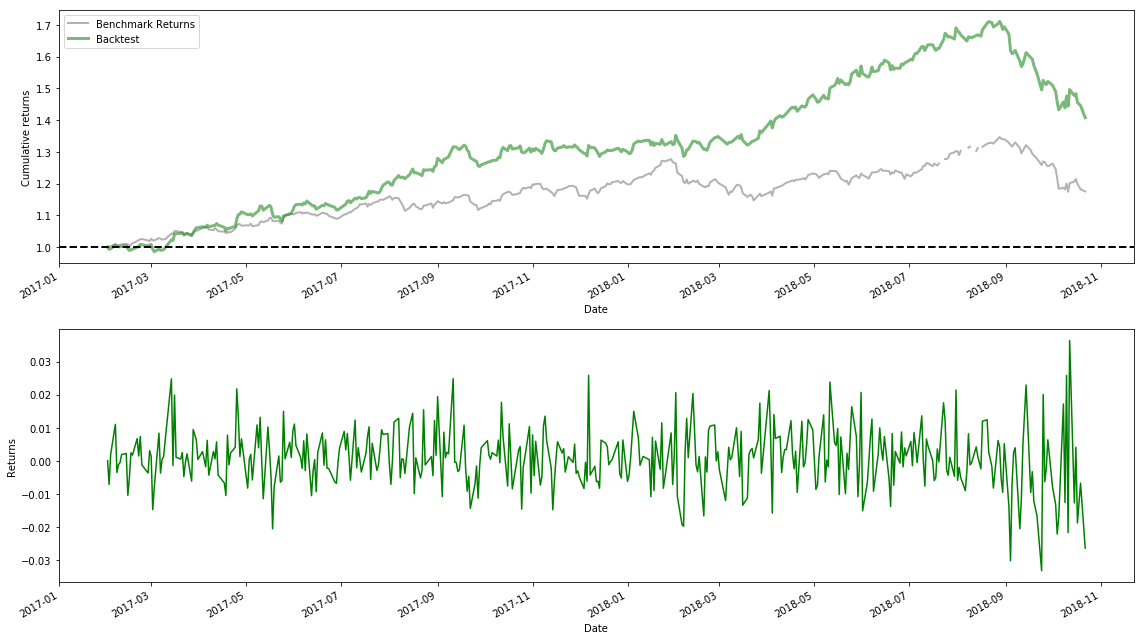

In [138]:
plt.figure(figsize=(16,9))

# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(portfolio_normalized_allocation['Daily Return'], benchmark_returns['Benchmark Returns'])

# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(portfolio_normalized_allocation['Daily Return'])
plt.tight_layout()

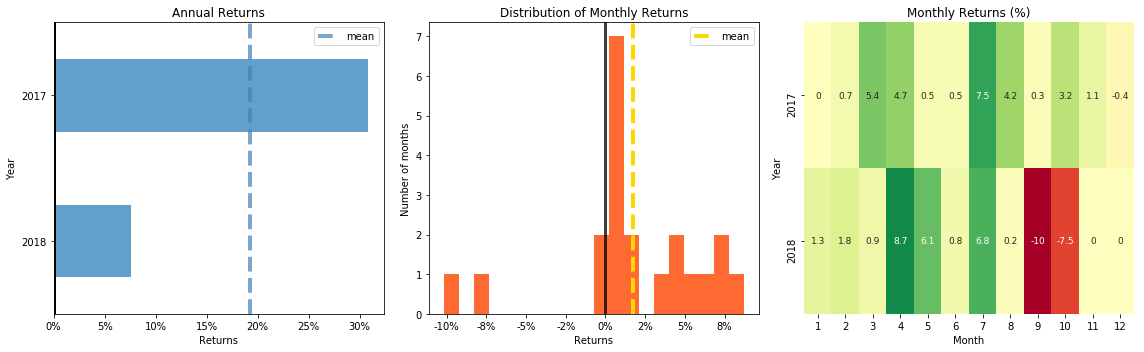

In [139]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
pf.plot_annual_returns(portfolio_normalized_allocation['Daily Return'])
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(portfolio_normalized_allocation['Daily Return'])
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(portfolio_normalized_allocation['Daily Return'])
plt.tight_layout()

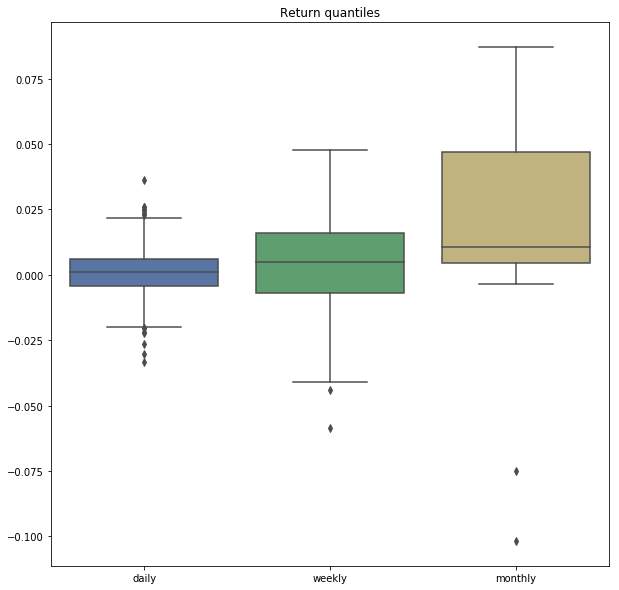

In [143]:
plt.figure(figsize=(10,10))
pf.plot_return_quantiles(portfolio_normalized_allocation['Daily Return']);

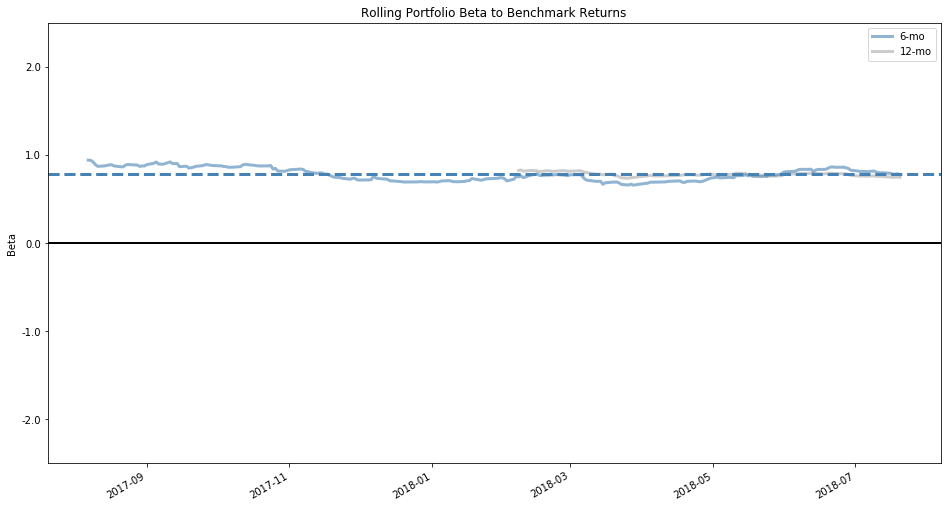

In [145]:
plt.figure(figsize=(16,9))
pf.plot_rolling_beta(portfolio_normalized_allocation['Daily Return'], benchmark_returns['Benchmark Returns']);

In [147]:
# Need to check if risk free rate of return can be configuired
#plt.figure(figsize=(16,9))
#pf.plot_rolling_sharpe(portfolio_normalized_allocation['Daily Return']);

In [151]:
plt.figure(figsize=(16,9))
#pf.plot_rolling_fama_french(portfolio_normalized_allocation['Daily Return']);

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

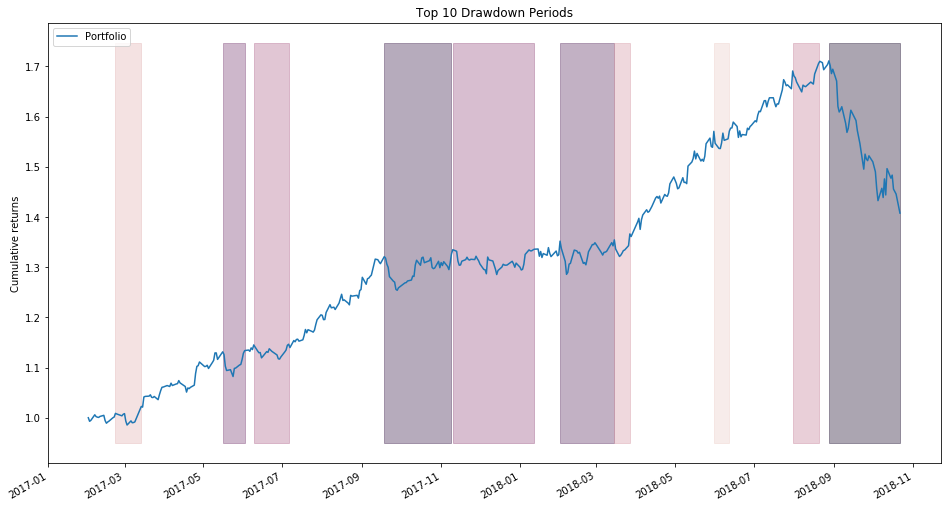

In [153]:
plt.figure(figsize=(16,9))
pf.plot_drawdown_periods(portfolio_normalized_allocation['Daily Return']);

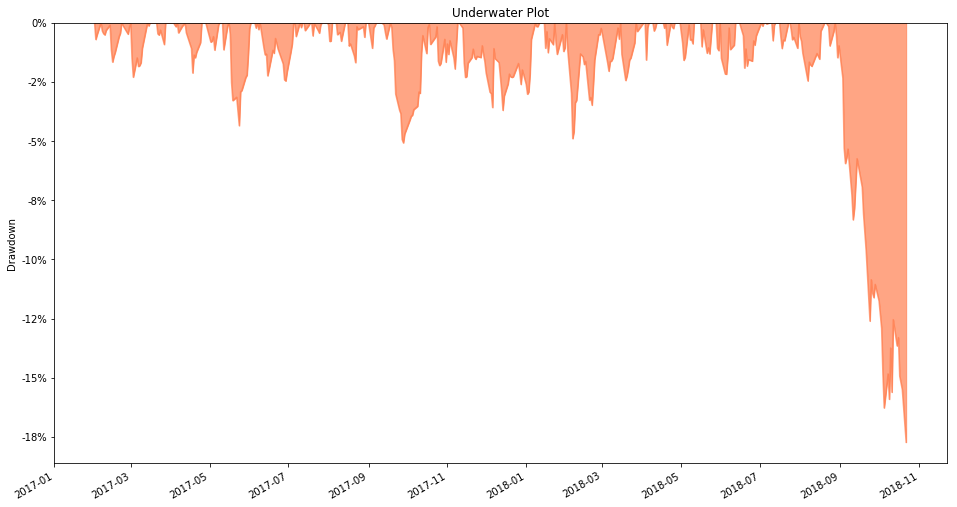

In [154]:
plt.figure(figsize=(16,9))
pf.plot_drawdown_underwater(portfolio_normalized_allocation['Daily Return']);